# Beth Hilbert ~ Expedia Dataset ~ Data Analytics Models

The dataset is part of a Kaggle Competition sponsored by Expedia. In this notebook, I create 3 models using Regression (OLS), Clustering (K-Means), and Classification (K-Nearest Neighbors) algorithms. This modeling section is set up so that you can easily maniuplate the variables in these models to experiment with different inputs (such as assigning a different targert or number of clusters). 

This is part 2 of my final project for the University of Cincinnati class "Analytics Using Python." See the other notebook (part 1) for Data Exploration.




## 1. Business Understanding

 

Expedia is a travel company booking website that is seeking to improve their algorithms used to suggest hotels. In order to accomplish this, they have created 100 clusters of similar hotels based on hotel popularity, rating, user review rating, price, distance from city center, and amenities. The goal of the Kaggle Competition is to predict which hotel cluster an Expedia user will book, based on their searching attributes and hotel information. Expedia has provided a dataset of customer searches, some of which includes what they searched for (number rooms, number people, dates, location), location where they the search from (site, channel, country where they initiated search), and the result (clicks and whether it resulted in a booking). 

## 2. Data Understanding

### Acquiring the Dataset From Kaggle

Expedia gave Kaggle three csv files (destination, train, and test). Destinations contains info about regions users searched in for hotels. Train and test are split based on year. Training data is from 2013/2014 and includes the clicks and books. Testing data is from 2015 and only includes booking events. For this reason, I selected training data. I downloaded the dataset from Kaggle - https://www.kaggle.com/c/expedia-hotel-recommendations and unzipped it using 7-Zip. 
These are the column names and descriptions as given by Kaggle:


### Import Modules

First I imported modules and assigned some of them an alias.

In [1]:
""" Import modules and set up plotting. """

import collections
import datetime
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as pl
import scipy
import seaborn as sb
import sklearn
import statsmodels.formula.api as smf
import statsmodels.api as sm

from pandas import Series, DataFrame
from pandas.tools.plotting import scatter_matrix
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

# Plotting Graphs Configuration
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 14, 7
plt.style.use('seaborn-whitegrid')


### Read Data Into the iPython Notebook

Using Pandas, I read the the data from the 'train.csv' file. I modified the data by converting some columns to boolean, some to dates, and adding columns for length of stay and number of people. Following this, I displayed the shape, column names/types, and header of the first 5 rows. 

In [2]:
""" Read data from the train.csv file using pandas."""

train = pd.read_csv("train.csv", nrows=1000)

In [3]:
""" Column Modifications, including converting (to boolean and date time) and adding a few calculated columns. """

# Converts subset of columns to boolean
train[['is_mobile', 'is_package', 'is_booking']] = train[['is_mobile', 'is_package', 'is_booking']].astype(np.bool)

# Converts subset of columns to dates
train['date_time'] = pd.to_datetime(train['date_time'], errors='coerce', yearfirst=True)
train['year'] = train['date_time'].dt.year
train['month'] = train['date_time'].dt.month
train['srch_co'] = pd.to_datetime(train['srch_co'], errors='coerce', yearfirst=True)
train['srch_ci'] = pd.to_datetime(train['srch_ci'], errors='coerce', yearfirst=True)

# Adds column for length of stay
srch_length_of_stay = train['srch_co'] - train['srch_ci']
train['srch_length_of_stay'] = srch_length_of_stay

# Adds column for number of people
srch_people_cnt = train['srch_adults_cnt'] + train['srch_children_cnt']
train['srch_people_cnt'] = srch_people_cnt

In [4]:
""" Data shape, column names/types, and header which displays a snapshot of the data. """

print
print "shape (rows, columns): " + str(train.shape)
print
print "data column name:\tdata type:"
print train.dtypes
print
print "Dataset:: ", str(train)
print
print "Header:"
train.head()


shape (rows, columns): (1000, 28)

data column name:	data type:
date_time                     datetime64[ns]
site_name                              int64
posa_continent                         int64
user_location_country                  int64
user_location_region                   int64
user_location_city                     int64
orig_destination_distance            float64
user_id                                int64
is_mobile                               bool
is_package                              bool
channel                                int64
srch_ci                       datetime64[ns]
srch_co                       datetime64[ns]
srch_adults_cnt                        int64
srch_children_cnt                      int64
srch_rm_cnt                            int64
srch_destination_id                    int64
srch_destination_type_id               int64
is_booking                              bool
cnt                                    int64
hotel_continent                    

date_time  site_name  posa_continent  user_location_country  \
0 2014-08-11 07:46:59          2               3                     66   
1 2014-08-11 08:22:12          2               3                     66   
2 2014-08-11 08:24:33          2               3                     66   
3 2014-08-09 18:05:16          2               3                     66   
4 2014-08-09 18:08:18          2               3                     66   

   user_location_region  user_location_city  orig_destination_distance  \
0                   348               48862                  2234.2641   
1                   348               48862                  2234.2641   
2                   348               48862                  2234.2641   
3                   442               35390                   913.1932   
4                   442               35390                   913.6259   

   user_id is_mobile is_package       ...         is_booking cnt  \
0       12     False       True       ...              False   3   
1       12     False       True       ...               True   1   
2       12     False      False       ...              False   1   
3       93     False      False       ...              False   1   
4       93     False      False       ...              False   1   

  hotel_continent  hotel_country  hotel_market  hotel_cluster  year  month  \
0               2             50           628              1  2014      8   
1               2             50           628              1  2014      8   
2               2             50           628              1  2014      8   
3               2             50          1457             80  2014      8   
4               2             50          1457             21  2014      8   

  srch_length_of_stay  srch_people_cnt  
0              4 days                2  
1              4 days                2  
2              4 days                2  
3              5 days                2  
4              5 days                2  

[5 rows x 28 columns]

# 3. Data Analytics Models

## Linear Regression Using OLS (Ordinary Least Squares)

The assignment asks us to perform regression to determine hotel_market value based on number of adults, number of children, number of rooms, and length of stay. Regression is used to predict a variable that is numeric or continuous in nature (such as price). While predictors may be categorical, the target must be a number. In the dataset, hotel_market is referenced as a number but it is not a continuous-valued attribute so these results make no sense. But for the sake of the assignment we will assume hotel_market is an attribute where a value can be calculated. 

For a linear regression, I selected the OLS method, which stands for ordinary least squares. The goal is to minimize the sum of the squares of the difference between the observed responses (value predicted for hotel_market) and those predicted by a linear set of explanatory variables (number of adults, number of children, number of rooms, length of stay). In this model, we are trying to determine how much the dependent variable (hotel_market) is influenced by these other variables. The resulting r-squared shows the resulting model explains very little of the variablilty of the response data around its mean. 

In [5]:
# Linear Regression Using OLS

""" Parameters to set """
filename = 'train.csv'
nrows = 1000

"""Read file, calculate length of stay column"""
data = pd.read_csv(filename, nrows=nrows)
data['srch_co'] = pd.to_datetime(data['srch_co'], errors='coerce', yearfirst=True)
data['srch_ci'] = pd.to_datetime(data['srch_ci'], errors='coerce', yearfirst=True)
srch_length_of_stay = data['srch_co'] - data['srch_ci']
data['srch_length_of_stay'] = srch_length_of_stay
data['srch_length_of_stay'] = pd.factorize(data['srch_length_of_stay'])[0]

"Linear Regression Model Implementation"
model = smf.ols('hotel_market ~ srch_adults_cnt + srch_children_cnt + srch_rm_cnt + srch_length_of_stay', data=data).fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:           hotel_market   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     27.68
Date:                Mon, 07 Aug 2017   Prob (F-statistic):           8.13e-22
Time:                        14:39:09   Log-Likelihood:                -7368.0
No. Observations:                1000   AIC:                         1.475e+04
Df Residuals:                     995   BIC:                         1.477e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              65.6552    

#### Influence Plot

The Influence Plot displays the outliers, leverage, and influence of each case. The point size is Cook's distance. Outliers are cases with large residual (vertical axis). Not all outliers are bad because some are interesting cases. Leverage (horizontal axis) is potenial for case to have influence on model. Cases with highest residual and leverage have the most influence so would affect the model the most if they are excluded. 

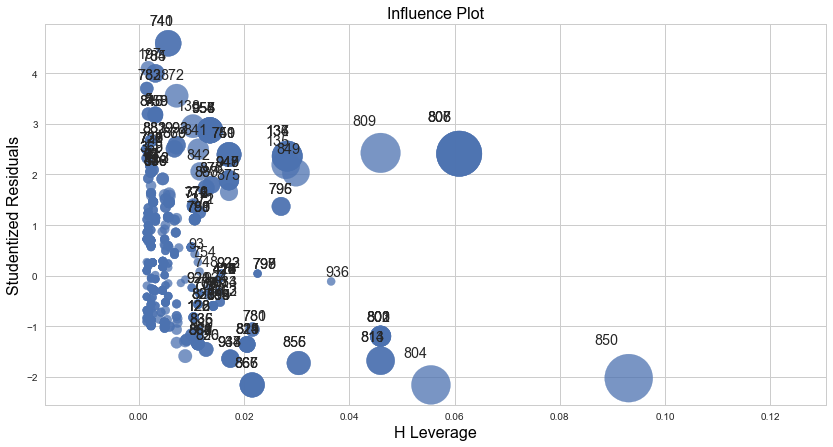

In [6]:
# Linear Regression Using OLS - Influence Plot

fig = plt.figure(figsize=(12,8))
fig = sm.graphics.influence_plot(model, criterion='cooks')

#### Partial Regression Plot

Partial regression shows the affect of adding variables to a model. None of these variables have much affect on prediction the hotel_market, as shown by the relatively flat slopes and dispersion from the line. 

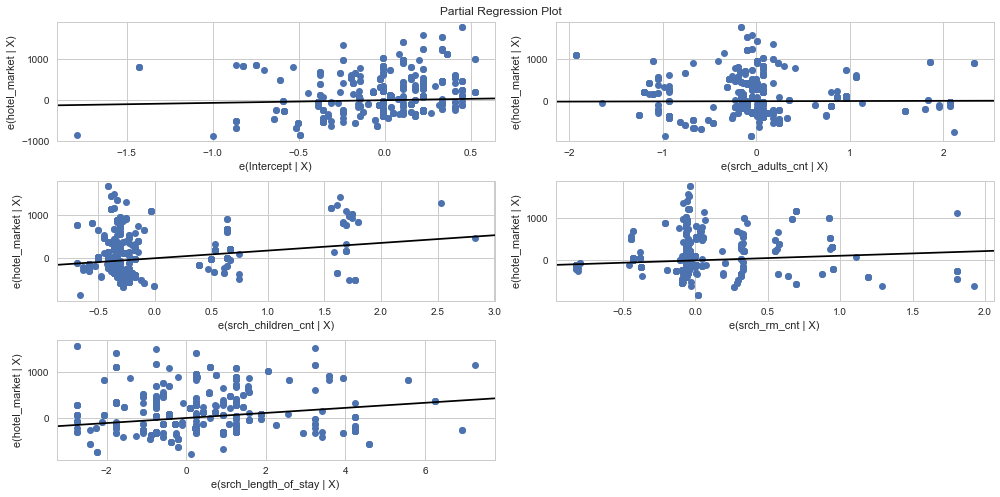

In [7]:
# Linear Regression Using OLS - Partial Regression Plots

fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(model)

#### Extra linear regression with meaningful data R-squared 

I also tried other variables for the use as the target, but within this dataset there are not good options for linear regression type predictions. So I stuck with hotel_market as the target but added the categorical values srch_destination_id and hotel_continent which increased the R-squared value. Categories can be predictors (if they are marked as categories), just not the target. By adding these categories, the R-squared value increased to 92% (100% indicates model explains all variablity of the response data around the mean). This indicates the using these predictors (srch_people_cnt, srch_rm_cnt, srch_length_of_stay, srch_destination_id, and hotel_continent) we can calculate a value for hotel_market.

In [8]:
# Linear Regression Using OLS

""" Parameters to set """
filename = 'train.csv'
nrows = 1000

"""Read file, calculate length of stay column"""
data = pd.read_csv(filename, nrows=nrows)
data['srch_co'] = pd.to_datetime(data['srch_co'], errors='coerce', yearfirst=True)
data['srch_ci'] = pd.to_datetime(data['srch_ci'], errors='coerce', yearfirst=True)
srch_length_of_stay = data['srch_co'] - data['srch_ci']
data['srch_length_of_stay'] = srch_length_of_stay
data['srch_length_of_stay'] = pd.factorize(data['srch_length_of_stay'])[0]

"Linear Regression Model Implementation"
model = smf.ols('hotel_market ~ srch_people_cnt + srch_rm_cnt + srch_length_of_stay + C(srch_destination_id) +C(hotel_continent)', data=data).fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:           hotel_market   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     70.25
Date:                Mon, 07 Aug 2017   Prob (F-statistic):               0.00
Time:                        14:39:11   Log-Likelihood:                -6148.6
No. Observations:                1000   AIC:                         1.259e+04
Df Residuals:                     856   BIC:                         1.329e+04
Df Model:                         143                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

## Clustering Using K-Means

Clustering analysis groups similar objects into sets such that the objects in a cluster are similar to one another (intra-cluster distances minimized) and different from objects in other clusters (inter-cluster distances maximized).  It is an unsupervised learning method in which there are no predefined classes or examples.  Clustering helps establish the existence of some sort of structure that might indicate that data is separable. 

Clustering, also known as market segmentation, is a strategic marketing concept: group people according to their similarity (in several dimensions related to a product under consideration) and then target marketing programs to these distinct groups. In our case, clustering could indicate subsets which tend to book certain hotels, which could then be used to improve Expedia’s hotel recommendation algorithm. 

To implement a clustering model, you tell the algorithm what features to analyze for similarity (predictors), how many clusters to create, and how to measure proximity (such as distance between points, distance from a centroid, data density, distribution models). Centroids are a good measure of proximity for multidimensional spaces and large datasets, both of which apply to this data set. K-means is a common centroid method.  I selected the K-means algorithm, in which K represents the number of clusters to create. In K-means you input the k (number of clusters) and features to use (I used almost all fields except dates and float). The model generates a set of K cluster centroids and a labeling assigning each point to a specific cluster. 

The K-means algorithm runs by partitioning the data into clusters such that the sum of squared distance from the centroid is minimized. It is an iterative approach in which the objects are first arbitrarily partitioned into k groups. Then it computes centroid (center point) for each group and assign each object to the cluster of its nearest centroid (which may not be in its current group). The partitions are redrawn, new centroids are calculated, each object is again assigned to closest centroid. This process continues until the assignments doesn’t change. 

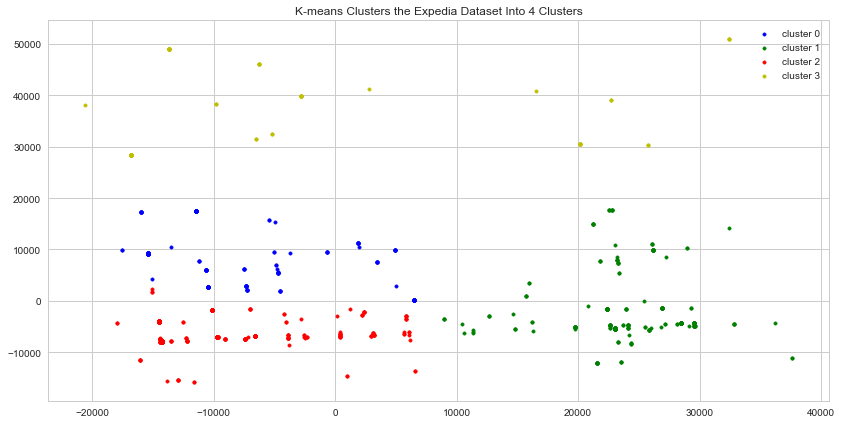

In [9]:
# Clustering Using K-Means

""" Parameters to set """
filename = 'train.csv'
nrows = 1000
k = 4   # will calculate any number of k, graph will show maximum k of 7. 

""" Read file, calculate length of stay, delete date columns.""" 
data = pd.read_csv(filename, nrows=nrows)
data['srch_co'] = pd.to_datetime(data['srch_co'], errors='coerce', yearfirst=True)
data['srch_ci'] = pd.to_datetime(data['srch_ci'], errors='coerce', yearfirst=True)
srch_length_of_stay = data['srch_co'] - data['srch_ci']
data['srch_length_of_stay'] = srch_length_of_stay
data['srch_length_of_stay'] = pd.factorize(data['srch_length_of_stay'])[0]
del data['date_time']
del data['srch_co']
del data['srch_ci']
del data['orig_destination_distance']

""" Run Clustering Algorithm """
kmeans = KMeans(n_clusters=k).fit(data)

""" Appending prediction column to dataset. """
data["predicted_cluster"] = kmeans.labels_
pca = PCA(n_components=2).fit(data)
pca_2d = pca.transform(data) 

""" Plotting with legend"""

c1=c2=c3=c4=c5=c6=[]
for i in range(0, nrows):
    if kmeans.labels_[i] == 0:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='b', marker='.')
    elif kmeans.labels_[i] == 1:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g', marker='.')
    elif kmeans.labels_[i] == 2:
        c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r', marker='.')
    elif kmeans.labels_[i] == 3:
        c4 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='y', marker='.')
    elif kmeans.labels_[i] == 4:
        c5 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='m', marker='.')   
    elif kmeans.labels_[i] == 5:
        c5 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='k', marker='.') 
    elif kmeans.labels_[i] == 6:
        c6 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='c', marker='.') 

legend_name = []
legend_numb = [c1, c2, c3, c4, c5, c6]   
for t in range(0,k):
    k_iter = "cluster " + str(t)
    legend_name.append(k_iter)
legend_numb = [c1, c2, c3, c4, c5, c6]    
plt.legend(legend_numb,legend_name)

plt.title('K-means Clusters the Expedia Dataset Into %s Clusters' % (k))
plt.show()

## Classification Using KNN (K-Nearest Neighbors)

Classification is an attempt to predict the result of new cases, after training with historic cases. The purpose of classification is to determine which bucket to put the case in, not what the buckets should be (which is a clustering). Classification is a model of supervised learning, where categories already exist in labeled data so there is a true outcome of what is the prediction is supposed to be.  The end result of the assigned classification model is determining if a specific TripSearch will result in a booking. Presumably this would be used by a computer to determine optimum hotel recommendations which would result in a booking, given the other variables of the user information, search information, and hotel information. Since the computer, not a person, will use the result this is a situation where a black box solution is adequate and a transparent method like decision tree is not necessary. 

I used the K-Nearest Neighbor Classifier (KNN) which predicts the target class label by finding the nearest neighbor class. The neighbor class is identified using a similarity (distance) measure. By finding similar events, we can predict whether this TripSearch will result in a booking. For KNN, model building involves deciding the class label (is_booking), the features (predictors used to classify the cases), the k-value, and the weight. KNN is instance based, which means it does not create an internal model. Instead the model calculates the label of a new case based on k-value and weight specified. It calculates this label by comparing the labels of the nearest k neighbors, which then vote (in weighted way) with the most predominant label of these neighbors being assigned as the label for this new case. No changes are made to the neighbors’ labels. 

My KNN model has two parts: calculations and implementation. The calculation kernel block is used to measure accuracy of varying k-values and distance measures. Accuracy is the ratio of correctly predicted cases to all cases. Accuracy helps us understand the effectiveness of our algorithm.  
The K-value is the number of neighbors to consider. Selecting the value of K is critical; a larger K results in greater execution time but a smaller K leads to overfitting. Distance is the similarity measure; a weight of “uniform” indicates all cases in the neighborhood are weighted equally whereas a weight of “distance” weighs the closer cases in the neighborhood higher.  

In the calculation kernel block, you will need to assign filename, features, and target. The target is the attribute you are predicting, in our case that is a True or False label to "is_booking". The features you use to train your model have a huge influence on performatince.  You want to select the features with that contribute the most to the prediction or output in which you are most interested. Irrelevant or partially relevant can decrease model accuracy..

The implementation kernel block runs the model and appends a column with the prediction label to the dataset. This model uses the fit and predict methods. You will need to assign the K-value and weight. I recommend using your results from the calculation kernel block to determine these values. The filename, features, and target are reused from the calculation kernel block. 



Target: is_booking
Predictors: 17 ['site_name', 'posa_continent', 'channel', 'user_location_country', 'user_location_region', 'user_location_city', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id', 'hotel_continent', 'hotel_country', 'hotel_market', 'hotel_cluster', 'is_package', 'is_mobile']

Accuracy: 84.486% 	K-value: 1 	Weight: uniform
Accuracy: 91.465% 	K-value: 2 	Weight: uniform
Accuracy: 90.374% 	K-value: 3 	Weight: uniform
Accuracy: 91.565% 	K-value: 4 	Weight: uniform
Accuracy: 91.333% 	K-value: 5 	Weight: uniform
Accuracy: 91.598% 	K-value: 6 	Weight: uniform
Accuracy: 91.234% 	K-value: 7 	Weight: uniform
Accuracy: 91.565% 	K-value: 8 	Weight: uniform
Accuracy: 91.532% 	K-value: 9 	Weight: uniform
Accuracy: 91.631% 	K-value: 10 	Weight: uniform
Accuracy: 91.631% 	K-value: 11 	Weight: uniform
Accuracy: 91.631% 	K-value: 12 	Weight: uniform
Accuracy: 91.631% 	K-value: 13 	Weight: uniform
Accuracy: 91.631% 	K-value: 14 	W

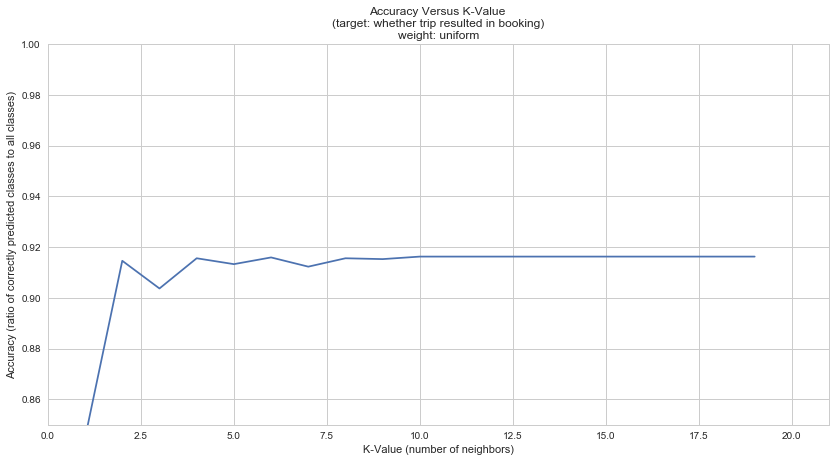

Accuracy: 84.486% 	K-value: 1 	Weight: distance
Accuracy: 86.404% 	K-value: 2 	Weight: distance
Accuracy: 86.636% 	K-value: 3 	Weight: distance
Accuracy: 86.669% 	K-value: 4 	Weight: distance
Accuracy: 86.867% 	K-value: 5 	Weight: distance
Accuracy: 86.867% 	K-value: 6 	Weight: distance
Accuracy: 86.9% 	K-value: 7 	Weight: distance
Accuracy: 86.934% 	K-value: 8 	Weight: distance
Accuracy: 86.934% 	K-value: 9 	Weight: distance
Accuracy: 86.967% 	K-value: 10 	Weight: distance
Accuracy: 86.967% 	K-value: 11 	Weight: distance
Accuracy: 86.967% 	K-value: 12 	Weight: distance
Accuracy: 86.967% 	K-value: 13 	Weight: distance
Accuracy: 86.967% 	K-value: 14 	Weight: distance
Accuracy: 87.0% 	K-value: 15 	Weight: distance
Accuracy: 87.033% 	K-value: 16 	Weight: distance
Accuracy: 87.033% 	K-value: 17 	Weight: distance
Accuracy: 87.033% 	K-value: 18 	Weight: distance
Accuracy: 87.033% 	K-value: 19 	Weight: distance


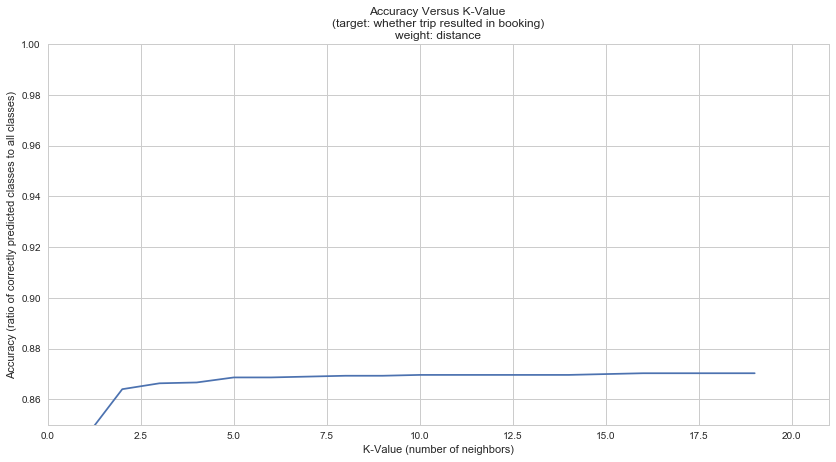

In [10]:
# KNN Model Calculations
# This evaluates at what value of K (number of neighbors) the accuracy peaks
# You can assign filename, nrows, features (columns to make predictions with), and target (what to predict)

""" Parameters to set """
filename = 'train.csv'
nrows = 10000
features = (['site_name', 'posa_continent', 'channel', 'user_location_country', 'user_location_region', 
             'user_location_city', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 
             'srch_destination_id', 'srch_destination_type_id', 'hotel_continent', 'hotel_country', 
             'hotel_market', 'hotel_cluster', 'is_package', 'is_mobile'])
target = 'is_booking'

""" Read file, divide file randomly into Training and Testing datasets.""" 
data = pd.read_csv(filename, nrows=nrows)
test_idx = np.random.uniform(0, 1, len(data)) <= 0.7    # 70% is training data
train = data[test_idx==True]
test = data[test_idx==False]

"""
Run KNN Classifier to determine optimum K and weight.
Loops through weight options and k-values calculating accuracy.
Displays and plots accuracy and at varying k-values.
"""
print
print "Target: " + str(target)
print "Predictors: " + str(len(features)) + " " + str(features)
print
all_results = []   # accuracy test results
for w in ['uniform', 'distance']:
    results = []    #accuray test results for this weight iteration
    for k in range(1, 20):   # maximum K-value tested is 20
        clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, weights=w)
        clf.fit(train[features], train[target])
        preds = clf.predict(test[features])
        accuracy = np.where(preds==test[target], 1, 0).sum() / float(len(test))
        accuracy_rounded = round(accuracy, 5)
        accuracy_percent = str(accuracy_rounded * 100) + "%"
        print "Accuracy: %s \tK-value: %d \tWeight: %s" % (accuracy_percent, k, w)
        results.append([k, accuracy, w])
    results = pd.DataFrame(results, columns=["k", "accuracy","w"])
    plt.plot(results.k, results.accuracy)
    plt.axis([0,21,.85,1])  
    plt.title("Accuracy Versus K-Value \n(target: whether trip resulted in booking)\nweight: %s" % (w)) 
    plt.xlabel("K-Value (number of neighbors)")
    plt.ylabel ("Accuracy (ratio of correctly predicted classes to all classes)")
    plt.show()
    all_results.append(results)

In [11]:
# KNN Model Implementation. 
# This runs the model and appends the prediction to the data file.
# You assign parametners for k-value and weight in this block

""" Parameters to set """
k_value = 6
weight = "uniform"   # options are uniform, distance, or user defined
# Other paramaters used which are assigned in KNN Calculation Kernal above: datafile, features (predictors), and target.

""" 
KNN Implementation 
Generates prediction, appends prediction as a column in the data file, calculate accuracy
"""
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k_value, weights=weight)
knn.fit(data[features], data[target])
predict = knn.predict(data[features])
data['is_book_prediction'] = predict
accuracy_percent =  str(knn.score(data[features], data[target]) * 100) + '%'

y_expect = data['is_booking']
y_predict = data['is_book_prediction']
print(metrics.classification_report(y_expect, y_predict))
print 
print "Accuracy: %s \tK-value: %d \tWeight: %s \tTarget: %s" % (accuracy_percent, k_value, weight, target)
print
print "Predictors: " + str(len(features)) + " " + str(features)
print
print "Dataset: "
data

             precision    recall  f1-score   support

          0       0.92      1.00      0.96      9223
          1       0.50      0.01      0.01       777

avg / total       0.89      0.92      0.89     10000


Accuracy: 92.23% 	K-value: 6 	Weight: uniform 	Target: is_booking

Predictors: 17 ['site_name', 'posa_continent', 'channel', 'user_location_country', 'user_location_region', 'user_location_city', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id', 'hotel_continent', 'hotel_country', 'hotel_market', 'hotel_cluster', 'is_package', 'is_mobile']

Dataset: 


date_time  site_name  posa_continent  user_location_country  \
0     2014-08-11 07:46:59          2               3                     66   
1     2014-08-11 08:22:12          2               3                     66   
2     2014-08-11 08:24:33          2               3                     66   
3     2014-08-09 18:05:16          2               3                     66   
4     2014-08-09 18:08:18          2               3                     66   
5     2014-08-09 18:13:12          2               3                     66   
6     2014-07-16 09:42:23          2               3                     66   
7     2014-07-16 09:45:48          2               3                     66   
8     2014-07-16 09:52:11          2               3                     66   
9     2014-07-16 09:55:24          2               3                     66   
10    2014-07-16 10:00:06          2               3                     66   
11    2014-07-16 10:02:58          2               3                     66   
12    2014-01-17 06:24:56          2               3                     66   
13    2014-01-18 14:33:31          2               3                     66   
14    2014-01-21 06:39:08          2               3                     66   
15    2014-01-21 06:40:18          2               3                     66   
16    2014-01-22 06:10:02          2               3                     66   
17    2014-01-24 11:52:04          2               3                     66   
18    2014-01-24 17:26:24          2               3                     66   
19    2014-02-27 17:44:23          2               3                     66   
20    2014-02-27 18:01:32          2               3                     66   
21    2014-12-30 09:50:51          2               3                     66   
22    2014-12-30 09:55:43          2               3                     66   
23    2014-12-30 09:56:26          2               3                     66   
24    2014-10-22 12:20:56          2               3                     66   
25    2014-11-10 12:38:02          2               3                     66   
26    2013-06-15 15:10:49         30               4                    195   
27    2013-06-15 15:38:05         30               4                    195   
28    2014-11-22 14:32:46         30               4                    195   
29    2014-11-22 14:37:05         30               4                    195   
...                   ...        ...             ...                    ...   
9970  2014-08-12 08:52:36          2               3                     66   
9971  2014-08-12 08:53:29          2               3                     66   
9972  2014-08-12 08:59:37          2               3                     66   
9973  2014-08-12 09:01:05          2               3                     66   
9974  2014-08-12 09:29:46          2               3                     66   
9975  2014-10-02 13:13:04          2               3                     66   
9976  2014-10-02 13:17:07          2               3                     66   
9977  2013-10-24 05:17:12         11               3                     54   
9978  2013-10-25 00:49:50         11               3                     54   
9979  2013-10-25 00:51:48         11               3                     54   
9980  2014-08-09 01:04:57          9               1                     32   
9981  2014-08-09 01:07:41          9               1                     32   
9982  2014-08-09 01:08:51          9               1                     32   
9983  2014-08-12 01:12:19          9               1                     32   
9984  2014-08-12 01:12:26          9               1                     32   
9985  2014-08-12 01:13:15          9               1                     32   
9986  2013-04-17 20:48:36          2               3                     66   
9987  2013-04-17 21:21:35          2               3                     66   
9988  2013-04-17 21:21:43          2               3              